# Using slopes as a way to quantify perceptible temperature change.

#### Apurva Raman and William Lu

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot_date
import seaborn as sns

import datetime as dt
from datetime import datetime
from IPython.display import display

import thinkstats2
import thinkplot

import statsmodels.formula.api as smf

In [2]:
stations = {'Seattle': 'WBAN:24233', 
            'Boston': 'WBAN:14739', 
            'Lexington': 'WBAN:93820', 
            'San Diego': 'WBAN:93107'}

selected_station = 'Seattle'

# Make a date parsing function with the correct format
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M')

# Read the CSV while parsing the dates
df = pd.read_csv("913023.csv", parse_dates=['DATE'], date_parser=dateparse)

/home/william/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,8,10,11,12,13,14,15,16,17,19,20,22,23,25,26,27,28,29,33,34,37,38,39,40,44,45,46,47,48,50,59,60,62,63,64,67,68,69,71,72,73,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Remove all columns except for STATION, DATE, DAILYAverageDryBulbTemp, DAILYPrecip
#Make a copy of the original DataFrame
seatac = df.copy(deep=True)

#Uses DATE column as row index for resampling purposes later
seatac.set_index('DATE', inplace=True)

#Select rows of data for Seattle (WBAN:24233)
seatac = seatac.loc[seatac['STATION'] == stations[selected_station]]

#Select columns with data we need
seatac = seatac[['STATION', 'DAILYAverageDryBulbTemp', 'DAILYPrecip']]

#Select 2015 data
seatac_2015 = seatac.copy(deep=True)
seatac_2015 = seatac_2015.ix['2005-01-01':'2005-12-31']
# display(seatac_2015)

In [4]:
# Turn all non-numerical values into NaN for columns that should be numbers (via coerce) 
seatac_2015['DAILYAverageDryBulbTemp'] = seatac_2015['DAILYAverageDryBulbTemp'].apply(pd.to_numeric, errors='coerce')
seatac_2015['DAILYPrecip'] = seatac_2015['DAILYPrecip'].apply(pd.to_numeric, errors='coerce')

#Drop rows where there is no DAILYAverageDryBulbTemp value
seatac_2015.dropna(subset=['DAILYAverageDryBulbTemp'], inplace=True)

# Replace NaN for precipitation with 0
seatac_2015['DAILYPrecip'].fillna(0, inplace=True)

# Replace trace amounts of precipitation ('T') with 0.00001
seatac_2015['DAILYPrecip'].replace('T', 0.00001, inplace=True)

# Downsamples data to 1 day -- temperatures are averaged and precipitation is added
seatac_2015 = seatac_2015.resample('1D').agg({'DAILYAverageDryBulbTemp': np.mean, 'DAILYPrecip': np.sum})

# Fills in upsampled data that is NaN with data from previous day
seatac_2015.DAILYAverageDryBulbTemp.fillna(method='pad', limit=2,inplace=True)
seatac_2015.DAILYPrecip.fillna(method='pad', limit=2, inplace=True)

# display(seatac_2015)

In [5]:
# Takes the 3 day moving average of temperature
seatac_2015['MOVAvg'] = seatac_2015.rolling(window='3D', min_periods=1).mean()['DAILYAverageDryBulbTemp']

# display(seatac_2015)

In [6]:
# Calculates deviation from the moving average for the previous three days of temperature data
for d in seatac_2015.index:
    if d.month == 1 and d.day == 1:
        seatac_2015.loc[d, 'DEVFromAvg'] = 0
    else:
        seatac_2015.loc[d, 'DEVFromAvg'] = seatac_2015.loc[d, 'DAILYAverageDryBulbTemp'] - seatac_2015.loc[d-1, 'MOVAvg']

seatac_2015['ISRising'] = seatac_2015.DEVFromAvg > 3

display(seatac_2015)

,DAILYPrecip,DAILYAverageDryBulbTemp,MOVAvg,DEVFromAvg,ISRising
DATE,,,,,
2005-01-01,0.05,41.0,41.000000,0.000000,False
2005-01-02,0.00,36.0,38.500000,-5.000000,False
2005-01-03,0.00,33.5,36.833333,-5.000000,False
2005-01-04,0.00,33.0,34.166667,-3.833333,False
2005-01-05,0.00,31.5,32.666667,-2.666667,False
2005-01-06,0.17,32.5,32.333333,-0.166667,False
2005-01-07,0.08,39.5,34.500000,7.166667,True
2005-01-08,0.02,38.0,36.666667,3.500000,True
2005-01-09,0.04,35.0,37.500000,-1.666667,False


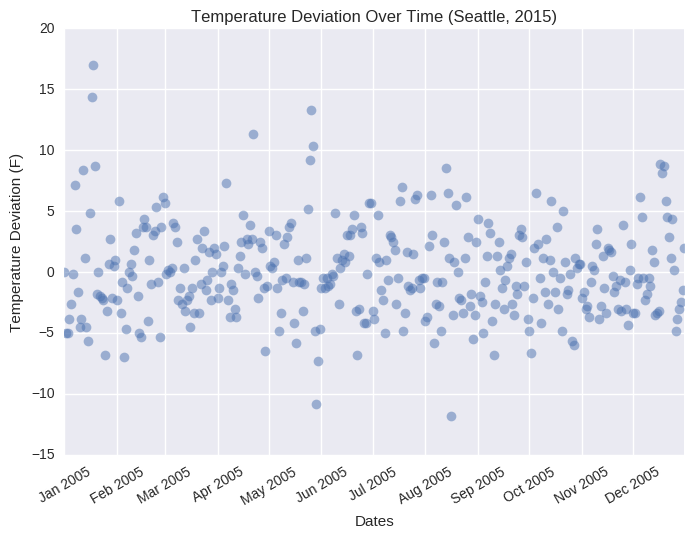

In [7]:
# Graph scatterplot of temperature deviations over time
temp_deviation = seatac_2015.copy(deep=True)
temp_deviation = temp_deviation['DEVFromAvg']

plot_date(seatac_2015.index.astype(datetime), seatac_2015.DEVFromAvg, alpha=0.5)
plt.xticks(rotation=30)
plt.xlabel('Dates')
plt.ylabel('Temperature Deviation (F)')
plt.title('Temperature Deviation Over Time (%s, 2015)' %(selected_station))
plt.show()

In [8]:
# Plot PMF of temperature deviations
all_temp_dev_pmf = thinkstats2.Pmf(temp_deviation.round(decimals=0), label='Deviation from 3 Day Moving Average')
# thinkplot.Pmf(all_temp_dev_pmf)
# thinkplot.Config(xlabel='Temperature Deviation (F)', ylabel='PMF')
# thinkplot.Show()

In [9]:
# Evaluates whether or not precipitation occurred on a day
seatac_2015['BOOLPrecip'] = seatac_2015.DAILYPrecip > 0
seatac_2015['BOOLPrecipNum'] = seatac_2015['BOOLPrecip'].astype(int)

display(seatac_2015)

,DAILYPrecip,DAILYAverageDryBulbTemp,MOVAvg,DEVFromAvg,ISRising,BOOLPrecip,BOOLPrecipNum
DATE,,,,,,,
2005-01-01,0.05,41.0,41.000000,0.000000,False,True,1
2005-01-02,0.00,36.0,38.500000,-5.000000,False,False,0
2005-01-03,0.00,33.5,36.833333,-5.000000,False,False,0
2005-01-04,0.00,33.0,34.166667,-3.833333,False,False,0
2005-01-05,0.00,31.5,32.666667,-2.666667,False,False,0
2005-01-06,0.17,32.5,32.333333,-0.166667,False,True,1
2005-01-07,0.08,39.5,34.500000,7.166667,True,True,1
2005-01-08,0.02,38.0,36.666667,3.500000,True,True,1
2005-01-09,0.04,35.0,37.500000,-1.666667,False,True,1


In [10]:
# Plots PMFs of all temperature deviation and temperature deviation when there is precipitation for comparison

seatac_2015_precip_true = seatac_2015[seatac_2015.BOOLPrecip == True].copy(deep=True)
precip_temp_dev_pmf = thinkstats2.Pmf(seatac_2015_precip_true['DEVFromAvg'].round(decimals=0), label='Precip True')

# thinkplot.Pmf(all_temp_dev_pmf)
# thinkplot.Pmf(precip_temp_dev_pmf)
# thinkplot.Config(xlabel='Temperature Deviation (F)', ylabel='PMF')
# thinkplot.Show()

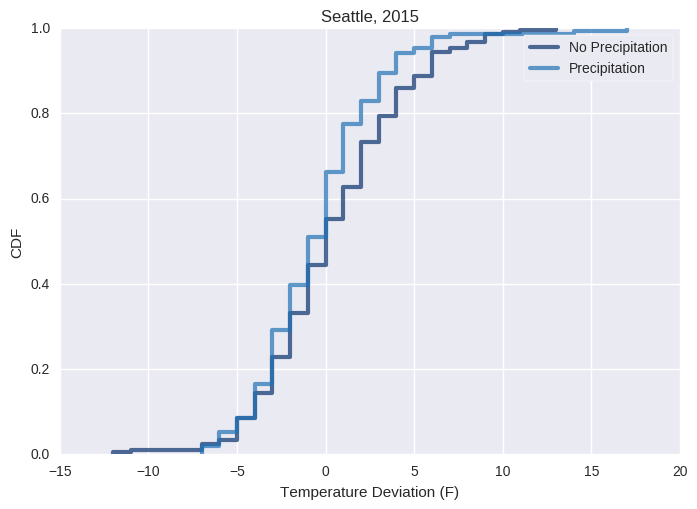

In [11]:
# Plots CDFs of all temperature deviation and temperature deviation when there is precipitation for comparison

seatac_2015_precip_false = seatac_2015[seatac_2015.BOOLPrecip == False].copy(deep=True)

noprecip_temp_dev_cdf = thinkstats2.Cdf(seatac_2015_precip_false['DEVFromAvg'].round(decimals=0), label='No Precipitation')
precip_temp_dev_cdf = thinkstats2.Cdf(seatac_2015_precip_true['DEVFromAvg'].round(decimals=0), label='Precipitation')

thinkplot.Cdf(noprecip_temp_dev_cdf)
thinkplot.Cdf(precip_temp_dev_cdf)
thinkplot.Config(xlabel='Temperature Deviation (F)', ylabel='CDF', title='%s, 2015' %(selected_station), loc='best')
thinkplot.Show()

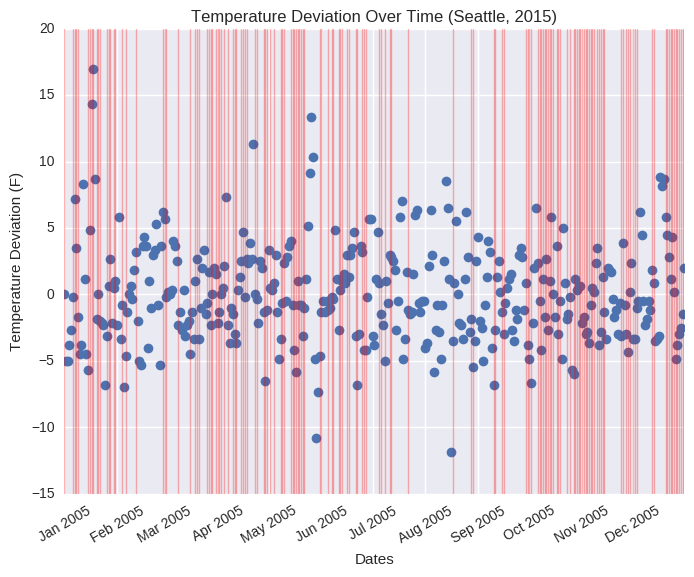

In [12]:
plot_date(seatac_2015.index.astype(datetime), seatac_2015.DEVFromAvg)

# Plots a red line on each date there is a precipitation event
for d in seatac_2015.index:
    if seatac_2015.ix[d].BOOLPrecip == True:
        plt.axvline(d, color='red', alpha=0.3, linewidth=1)

plt.xticks(rotation=30)
plt.xlabel('Dates')
plt.ylabel('Temperature Deviation (F)')
plt.title('Temperature Deviation Over Time (%s, 2015)' %(selected_station))
plt.show()

In [13]:
formula = 'seatac_2015.BOOLPrecipNum ~ seatac_2015.DEVFromAvg + seatac_2015.ISRising'
model = smf.logit(formula, data=seatac_2015)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.668613
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                              
=====================================================================================
Dep. Variable:     seatac_2015.BOOLPrecipNum   No. Observations:                  365
Model:                                 Logit   Df Residuals:                      362
Method:                                  MLE   Df Model:                            2
Date:                       Sat, 25 Mar 2017   Pseudo R-squ.:                 0.01410
Time:                               15:19:52   Log-Likelihood:                -244.04
converged:                              True   LL-Null:                       -247.53
                                               LLR p-value:                   0.03048
================================================================================================
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                       -0.2387      0.127     -1.875      0.061        -0.488     0.011
seatac_2015.ISRising[T.True]    -0.6621      0.418     -1.584      0.113        -1.481     0.157
seatac_2015.DEVFromAvg          -0.0138      0.041     -0.333      0.739        -0.095     0.067
================================================================================================
"""